<a href="https://colab.research.google.com/github/siruku6/thesis-trial/blob/master/240324_PPO_BipedalWalker_trial_softplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PPO のハイパーパラメータなどの修正による、性能改善への取り組み

- 利用環境
`BipedalWalker-v3`

## 取り組み事項

以下の変更を行って、性能の変化を確認した

1. GAE (Generalized Advantage Estimation) の $\lambda$ の値を 0.9 に変更
1. 行動の標準偏差を算出する際の活性化関数を softplus に変更
1. ネットワークの初期パラメータの工夫
    - 最終層の初期値を、
        - 重みについては、ランダムな初期値 * 0.01 の値で上書きして初期化
        - バイアスについては、全て 0 で初期化
1. 割引率 $\gamma$ の値を 0.99 に変更


## 結果

- 取り組み内容 1, 3, 4 については、性能改善に寄与している様子が確認できた
。
- 2 については実装方法が誤っていると思われるが、修正を行った結果、学習が進まなくなってしまい、学習途中でのエラーも発生した。

## 0. References

- [What Matters In On-Policy Reinforcement Learning? A Large-Scale Empirical Study (Original paper)](https://arxiv.org/abs/2006.05990)
- [What Matters In On-Policy Reinforcement Learning? A Large-Scale Empirical Study (Summary)](https://vitalab.github.io/article/2020/07/02/What_Matters_in_RL.html)
- [What Matters In On-Policy Reinforcement Learning? A Large-Scale Empirical Study (Japanese)](https://github.com/arXivTimes/arXivTimes/issues/1741)

## 1. 環境構築

In [ ]:
!apt install -y swig python3-opengl

!pip install -q setuptools==65.5.1 pip==21
!pip install -q gym[box2d]==0.21.0

!apt update > /dev/null 2>&1
!apt install xvfb > /dev/null 2>&1

!pip install -q gym-notebook-wrapper pyglet==1.5.0


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
# 必要なライブラリのインポート．
from typing import Any, Dict, List

from abc import ABC, abstractmethod
import os
import glob
from collections import deque
from time import time
from datetime import timedelta
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.distributions import Normal
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import gym
import gnwrapper

# Gymの警告を一部無視する．
gym.logger.set_level(40)
# matplotlibをColab上で描画するためのコマンド．
%matplotlib inline


In [ ]:
# 利用した Python モジュールのバージョン
!pip list | grep pyglet

pyglet                           1.5.0


## 2. ランダムポリシーでの動作確認

In [ ]:
ENV_ID = 'BipedalWalker-v3'
env = gym.make(ENV_ID)

monitor_env = gnwrapper.Monitor(
    env, size=(200, 200), directory='.', video_callable=lambda ep: True
)


print('observation space: ', monitor_env.observation_space)
print('action space: ', monitor_env.action_space)

monitor_env.reset()
done = False

# 終了シグナル(done=True)が返ってくるまで，ランダムに環境を動かす．
while (not done):
  action = monitor_env.action_space.sample()
  _, _, done, _ = monitor_env.step(action)


monitor_env.display()

del env

observation space:  Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf], (24,), float32)
action space:  Box([-1. -1. -1. -1.], [1. 1. 1. 1.], (4,), float32)


'rl-video-episode-0.mp4'

## 3. 関数 / クラスの実装


### 3-1. Trainer

一定のステップ間データ収集・学習・評価を繰り返す `Trainer` クラスを利用

In [ ]:
class Trainer:

    def __init__(
        self, env, env_test, algo, seed=0,
        num_steps=10**6, eval_interval=10**4, num_eval_episodes=3
      ):

        self.env = env
        self.env_test = env_test
        self.algo = algo

        # 環境の乱数シードを設定する．
        self.env.seed(seed)
        self.env_test.seed(2 ** 31 - seed)

        # 平均収益を保存するための辞書．
        self.returns = {'step': [], 'return': []}

        # データ収集を行うステップ数．
        self.num_steps = num_steps
        # 評価の間のステップ数(インターバル)．
        self.eval_interval = eval_interval
        # 評価を行うエピソード数．
        self.num_eval_episodes = num_eval_episodes

    def train(self):
        """ num_stepsステップの間，データ収集・学習・評価を繰り返す． """

        # 学習開始の時間
        self.start_time = time()
        # エピソードのステップ数．
        t = 0

        # 環境を初期化する．
        state = self.env.reset()

        for steps in range(1, self.num_steps + 1):
            # 環境(self.env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            # アルゴリズムに渡し，状態・エピソードのステップ数を更新する．
            state, t = self.algo.step(self.env, state, t, steps)

            # アルゴリズムが準備できていれば，1回学習を行う．
            if self.algo.is_update(steps):
                self.algo.update()

            # 一定のインターバルで評価する．
            if steps % self.eval_interval == 0:
                self.evaluate(steps)

    def evaluate(self, steps):
        """ 複数エピソード環境を動かし，平均収益を記録する． """

        returns = []
        for _ in range(self.num_eval_episodes):
            state = self.env_test.reset()
            done = False
            episode_return = 0.0

            while (not done):
                action = self.algo.exploit(state)
                state, reward, done, _ = self.env_test.step(action)
                episode_return += reward

            returns.append(episode_return)

        mean_return = np.mean(returns)
        self.returns['step'].append(steps)
        self.returns['return'].append(mean_return)

        print(f'Num steps: {steps:<6}   '
              f'Return: {mean_return:<5.1f}   '
              f'Time: {self.time}')

    def plot(self):
        """ 平均収益のグラフを描画する． """
        fig = plt.figure(figsize=(6, 4))
        plt.plot(self.returns['step'], self.returns['return'])
        plt.xlabel('Steps', fontsize=16)
        plt.ylabel('Return', fontsize=16)
        plt.tick_params(labelsize=9)
        plt.title(f'{self.env.unwrapped.spec.id}', fontsize=16)
        plt.tight_layout()

    @property
    def time(self):
        """ 学習開始からの経過時間． """
        return str(timedelta(seconds=int(time() - self.start_time)))

### 3-2. Mathematical methods

In [ ]:
def calculate_log_pi(log_stds, noises, actions):
    """ 確率論的な行動の確率密度を返す． """
    # ガウス分布 `N(0, stds * I)` における `noises * stds` の確率密度の対数(= \log \pi(u|a))を計算する．
    # 講義スライド（20211117_lec-2_2_発展的方策勾配法.pdf）のスライドの最後の2ページに計算方法が書いてある。
    log_pis = (
        - 0.5 * math.log(2 * math.pi) * log_stds.size(-1)
        # - log_stds.sum(dim=-1, keepdim=True)
        # - (0.5 * noises.pow(2)).sum(dim=-1, keepdim=True)
        + (-0.5 * noises.pow(2) - log_stds).sum(dim=-1, keepdim=True)
    )
    log_pis -= torch.log(1 - actions.pow(2) + 1e-6).sum(dim=-1, keepdim=True)

    return log_pis


def atanh(x):
    """ tanh の逆関数． """
    return 0.5 * (torch.log(1 + x + 1e-6) - torch.log(1 - x + 1e-6))


def evaluate_lop_pi(means, log_stds, actions):
    """ 平均(mean)，標準偏差の対数(log_stds)でパラメータ化した方策における，行動(actions)の確率密度の対数を計算する． """
    noises = (atanh(actions) - means) / (log_stds.exp() + 1e-8)
    return calculate_log_pi(log_stds, noises, actions)


In [ ]:
torch.tensor([2.7181]).log().exp()

tensor([2.7181])

### 3-3. Statistical methods

In [ ]:
def reparameterize(means, log_stds):
    """ Reparameterization Trickを用いて，確率論的な行動とその確率密度を返す． """
    # 標準偏差．
    stds = log_stds.exp()
    # 標準ガウス分布から，ノイズをサンプリングする．
    noises = torch.randn_like(means)
    # Reparameterization Trickを用いて，N(means, stds)からのサンプルを計算する．
    us = means + noises * stds
    # tanh　を適用し，確率論的な行動を計算する．
    actions = torch.tanh(us)

    # 確率論的な行動の確率密度の対数を計算する．
    log_pis = calculate_log_pi(log_stds, noises, actions)

    return actions, log_pis


### 3-4. Algorithm (Base and PPO)

#### PPO

```python
# Base
class PPOActor(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_shape[0]),
        )
        self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))

    def forward(self, states):
        return torch.tanh(self.net(states))

    def sample(self, states):
        return reparameterize(self.net(states), self.log_stds)

    def evaluate_log_pi(self, states, actions):
        return evaluate_lop_pi(self.net(states), self.log_stds, actions)
```

In [ ]:
# # NOTE: 3rd trial で使用した PPOActor クラス
# class PPOActor(nn.Module):

#     def __init__(self, state_shape, action_shape):
#         super().__init__()

#         self.net = nn.Sequential(
#             nn.Linear(state_shape[0], 64),
#             nn.Tanh(),
#             nn.Linear(64, 64),
#             nn.Tanh(),
#         )
#         self.mu_head = nn.Linear(64, action_shape[0])
#         self.sigma_head = nn.Linear(64, action_shape[0])
#         self.softplus = nn.Softplus()
#         # self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))

#     def forward(self, states):
#         x = self.net(states)
#         means = self.mu_head(x)
#         return torch.tanh(means)

#     def sample(self, states):
#         x = self.net(states)
#         means = self.mu_head(x)
#         log_stds = self.softplus(self.sigma_head(x))
#         return reparameterize(means, log_stds)

#     def evaluate_log_pi(self, states, actions):
#         x = self.net(states)
#         means = self.mu_head(x)
#         log_stds = self.softplus(self.sigma_head(x))
#         return evaluate_lop_pi(means, log_stds, actions)


# NOTE: 4th trial 以降で使用した PPOActor クラス
class PPOActor(nn.Module):
    """
    Updated!

    Following lines are added after initializing network parameters

    ```python
    with torch.no_grad():
        self.net[-1].weight.mul_(0.01)

    nn.init.constant_(self.net[-1].bias, 0)
    ```

    """

    def __init__(self, state_shape, action_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
        )
        self.mu_head = nn.Linear(64, action_shape[0])
        self.sigma_head = nn.Linear(64, action_shape[0])

        # ----------------------------------------------------------------------------
        # NOTE: Overwrite weights and biases by small values.
        #     Base, 2nd trial の時は、この箇所をコメントアウトする
        # ----------------------------------------------------------------------------
        # with torch.no_grad():
        #     self.net[-1].weight.mul_(0.01)

        # nn.init.constant_(self.net[-1].bias, 0)
        with torch.no_grad():
            self.mu_head.weight.mul_(0.01)

        nn.init.constant_(self.mu_head.bias, 0)
        # ----------------------------------------------------------------------------

        self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))

    def forward(self, states):
        x = self.net(states)
        means = self.mu_head(x)
        return torch.tanh(means)

    def sample(self, states):
        x = self.net(states)
        means = self.mu_head(x)
        return reparameterize(means, self.log_stds)

    def evaluate_log_pi(self, states, actions):
        x = self.net(states)
        means = self.mu_head(x)
        return evaluate_lop_pi(means, self.log_stds, actions)


class PPOCritic(nn.Module):

    def __init__(self, state_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, states):
        return self.net(states)

In [ ]:
state_shape = env.observation_space.shape
action_shape = env.action_space.shape

state = torch.tensor([
    0.2, 0.91, 0.01, 0.32,
    0.2, 0.91, 0.01, 0.32,
    0.2, 0.91, 0.01, 0.32,
    0.2, 0.91, 0.01, 0.32,
    0.2, 0.91, 0.01, 0.32,
    0.2, 0.91, 0.01, 0.32,
])
log_stds_ = torch.zeros(1, 4)

actor = PPOActor(state_shape, action_shape)
action = actor(state)
# evaluate_lop_pi(actor.net(state), log_stds_, action).cpu().item()


means = atanh(actor(state))
log_stds = log_stds_ + 1e-8
actions = action

# ------- def evaluate_lop_pi(means, log_stds, actions)
noises = (atanh(actions) - means) / (log_stds.exp() + 1e-8)
# calculate_log_pi(log_stds, noises, actions).cpu().item()



# def calculate_log_pi(log_stds, noises, actions):
""" 確率論的な行動の確率密度を返す． """
# ガウス分布 `N(0, stds * I)` における `noises * stds` の確率密度の対数(= \log \pi(u|a))を計算する．
# 講義スライド（20211117_lec-2_2_発展的方策勾配法.pdf）のスライドの最後の2ページに計算方法が書いてある。
log_pis = (
    - 0.5 * math.log(2 * math.pi) * log_stds.size(-1)
    + (-0.5 * noises.pow(2) - log_stds).sum(dim=-1, keepdim=True)
)
log_pis -= torch.log(1 - actions.pow(2) + 1e-6).sum(dim=-1, keepdim=True)
log_pis


tensor([[-3.6758]], grad_fn=<SubBackward0>)

In [ ]:
state, actor.log_stds

In [ ]:
_length = 10000
_sum = 0
with torch.no_grad():
    for i in tqdm(range(0, _length)):
        _sum += actor.sample(state)[1]

print(_sum / _length)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor([[-2.6782]])


In [ ]:
_length = 10000
_sum = 0
with torch.no_grad():
    for i in tqdm(range(0, _length)):
        means = atanh(actor(state))
        n = Normal(means, torch.nn.Softplus()(log_stds))
        action = n.sample()
        _sum += n.log_prob(action).sum()

print(_sum / _length)


  0%|          | 0/10000 [00:00<?, ?it/s]

tensor(-4.2163)


In [ ]:
def calculate_advantage(values, rewards, dones, next_values, gamma=0.995, lambd=0.997):
    """ GAEを用いて，状態価値のターゲットとGAEを計算する． """

    # TD誤差を計算する．
    deltas = rewards + gamma * next_values * (1 - dones) - values

    # GAEを初期化する．
    advantages = torch.empty_like(rewards)

    # 終端ステップを計算する．
    advantages[-1] = deltas[-1]

    # 終端ステップの1つ前から，順番にGAEを計算していく．
    for t in reversed(range(rewards.size(0) - 1)):
        advantages[t] = deltas[t] + gamma * lambd * (1 - dones[t]) * advantages[t + 1]

    # 状態価値のターゲットをλ-収益として計算する．
    targets = advantages + values

    # GAEを標準化する．
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return targets, advantages


In [ ]:
class RolloutBuffer:

    def __init__(self, buffer_size, state_shape, action_shape, device=torch.device('cuda')):

        # GPU上に保存するデータ．
        self.states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.log_pis = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.next_states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)

        # 次にデータを挿入するインデックス．
        self._p = 0
        # バッファのサイズ．
        self.buffer_size = buffer_size

    def append(self, state, action, reward, done, log_pi, next_state):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.log_pis[self._p] = float(log_pi)
        self.next_states[self._p].copy_(torch.from_numpy(next_state))
        self._p = (self._p + 1) % self.buffer_size

    def get(self):
        assert self._p == 0, 'Buffer needs to be full before training.'
        return self.states, self.actions, self.rewards, self.dones, self.log_pis, self.next_states


In [ ]:
class Algorithm(ABC):

    def explore(self, state):
        """ 確率論的な行動と，その行動の確率密度の対数 \log(\pi(a|s)) を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action, log_pi = self.actor.sample(state)  # reparametrize
        return action.cpu().numpy()[0], log_pi.item()

    def exploit(self, state):
        """ 決定論的な行動を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action = self.actor(state)  # tanh(net(state))
        return action.cpu().numpy()[0]

    @abstractmethod
    def is_update(self, steps):
        """ 現在のトータルのステップ数(steps)を受け取り，アルゴリズムを学習するか否かを返す． """
        pass

    @abstractmethod
    def step(self, env, state, t, steps):
        """ 環境(env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            受け取り，リプレイバッファへの保存などの処理を行い，状態・エピソードのステップ数を更新する．
        """
        pass

    @abstractmethod
    def update(self):
        """ 1回分の学習を行う． """
        pass


class PPO(Algorithm):

    def __init__(self, state_shape, action_shape, device=torch.device('cuda'), seed=0,
                 batch_size=64, gamma=0.995, lr_actor=3e-4, lr_critic=3e-4,
                 rollout_length=2048, num_updates=10, clip_eps=0.2, lambd=0.97,
                 coef_ent=0.0, max_grad_norm=0.5):
        super().__init__()

        # シードを設定する．
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        # データ保存用のバッファ．
        self.buffer = RolloutBuffer(
            buffer_size=rollout_length,
            state_shape=state_shape,
            action_shape=action_shape,
            device=device
        )

        # Actor-Criticのネットワークを構築する．
        self.actor = PPOActor(
            state_shape=state_shape,
            action_shape=action_shape,
        ).to(device)
        self.critic = PPOCritic(
            state_shape=state_shape,
        ).to(device)

        # オプティマイザ．
        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)

        # その他パラメータ．
        self.learning_steps = 0
        self.device = device
        self.batch_size = batch_size
        self.gamma = gamma
        self.rollout_length = rollout_length
        self.num_updates = num_updates
        self.clip_eps = clip_eps
        self.lambd = lambd
        self.coef_ent = coef_ent
        self.max_grad_norm = max_grad_norm

    def is_update(self, steps):
        # ロールアウト1回分のデータが溜まったら学習する．
        return steps % self.rollout_length == 0

    def step(self, env, state, t, steps):
        t += 1

        action, log_pi = self.explore(state)
        next_state, reward, done, _ = env.step(action)

        # ゲームオーバーではなく，最大ステップ数に到達したことでエピソードが終了した場合は，
        # 本来であればその先も試行が継続するはず．よって，終了シグナルをFalseにする．
        # NOTE: ゲームオーバーによってエピソード終了した場合には， done_masked=True が適切．
        # しかし，以下の実装では，"たまたま"最大ステップ数でゲームオーバーとなった場合には，
        # done_masked=False になってしまう．
        # その場合は稀で，多くの実装ではその誤差を無視しているので，今回も無視する．
        if t == env._max_episode_steps:
            done_masked = False
        else:
            done_masked = done

        # バッファにデータを追加する．
        self.buffer.append(state, action, reward, done_masked, log_pi, next_state)

        # エピソードが終了した場合には，環境をリセットする．
        if done:
            t = 0
            next_state = env.reset()

        return next_state, t

    def update(self):
        self.learning_steps += 1

        states, actions, rewards, dones, log_pis, next_states = self.buffer.get()

        with torch.no_grad():
            values = self.critic(states)
            next_values = self.critic(next_states)
        targets, advantages = calculate_advantage(values, rewards, dones, next_values, self.gamma, self.lambd)

        # バッファ内のデータを num_updates回ずつ使って，ネットワークを更新する．
        for _ in range(self.num_updates):
            # インデックスをシャッフルする．
            indices = np.arange(self.rollout_length)
            np.random.shuffle(indices)

            # ミニバッチに分けて学習する．
            for start in range(0, self.rollout_length, self.batch_size):
                idxes = indices[start:start+self.batch_size]
                self.update_critic(states[idxes], targets[idxes])
                self.update_actor(states[idxes], actions[idxes], log_pis[idxes], advantages[idxes])

    def update_critic(self, states, targets):
        loss_critic = (self.critic(states) - targets).pow_(2).mean()

        self.optim_critic.zero_grad()
        loss_critic.backward(retain_graph=False)
        # 学習を安定させるヒューリスティックとして，勾配のノルムをクリッピングする．
        nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
        self.optim_critic.step()

    def evaluate_lop_pi(self, means, log_stds, actions):
        """ 平均(mean)，標準偏差の対数(log_stds)でパラメータ化した方策における，行動(actions)の確率密度の対数を計算する． """
        noises = (atanh(actions) - means) / (log_stds.exp() + 1e-8)
        return calculate_log_pi(log_stds, noises, actions)

    def update_actor(self, states, actions, log_pis_old, advantages):
        # log_pis = self.actor.evaluate_log_pi(states, actions)
        means = atanh(self.actor(states))
        log_pis = self.evaluate_lop_pi(means, self.actor.log_stds, actions)
        mean_entropy = -log_pis.mean()

        ratios = (log_pis - log_pis_old).exp_()
        loss_actor1 = -ratios * advantages
        loss_actor2 = -torch.clamp(
            ratios,
            1.0 - self.clip_eps,
            1.0 + self.clip_eps
        ) * advantages
        loss_actor = torch.max(loss_actor1, loss_actor2).mean() - self.coef_ent * mean_entropy

        self.optim_actor.zero_grad()
        loss_actor.backward(retain_graph=False)
        # 学習を安定させるヒューリスティックとして，勾配のノルムをクリッピングする．
        nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
        self.optim_actor.step()


## 4. Experiments

### 4-1. Base trial

- 講座で提供されていたパラメータをそのまま使用した場合。

In [ ]:
ENV_ID = 'BipedalWalker-v3'
# ENV_ID = 'HalfCheetahBulletEnv-v0'
SEED = 0
NUM_STEPS = 3 * 10 ** 5
EVAL_INTERVAL = 10 ** 4

env = gym.make(ENV_ID)
env_test = gym.make(ENV_ID)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device('cpu')
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)


Num steps: 10000    Return: -68.7   Time: 0:00:22
Num steps: 20000    Return: -59.1   Time: 0:00:38
Num steps: 30000    Return: -95.5   Time: 0:00:54
Num steps: 40000    Return: -108.8   Time: 0:01:10
Num steps: 50000    Return: -61.6   Time: 0:01:30
Num steps: 60000    Return: -50.7   Time: 0:01:50
Num steps: 70000    Return: -127.3   Time: 0:02:05
Num steps: 80000    Return: -126.6   Time: 0:02:21
Num steps: 90000    Return: 107.1   Time: 0:02:51
Num steps: 100000   Return: 82.7    Time: 0:03:18
Num steps: 110000   Return: 87.9    Time: 0:03:36
Num steps: 120000   Return: 109.9   Time: 0:03:57
Num steps: 130000   Return: 99.7    Time: 0:04:17
Num steps: 140000   Return: 107.9   Time: 0:04:39
Num steps: 150000   Return: 137.8   Time: 0:05:08
Num steps: 160000   Return: 159.0   Time: 0:05:27
Num steps: 170000   Return: 167.1   Time: 0:05:44
Num steps: 180000   Return: 152.3   Time: 0:06:01
Num steps: 190000   Return: 169.2   Time: 0:06:18
Num steps: 200000   Return: -42.5   Time: 0:06:

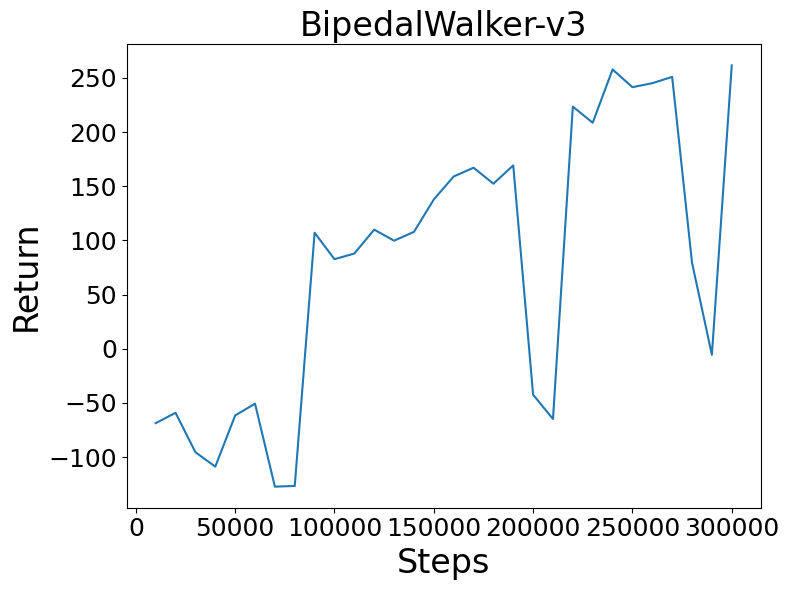

In [ ]:
trainer.train()
trainer.plot()


In [ ]:
def run_policy(env, algorithm) -> List[Dict[str, Any]]:
    """
    強化学習アルゴリズムによる、環境動作確認
    """
    state = env.reset()
    done: bool = False
    with torch.no_grad():
        # while (not done):
        for _ in tqdm(range(0, 99999), desc="steps"):
            action = algorithm.exploit(state)
            state, _, done, _ = env.step(action)
            if done:
              break

    env.close()


In [ ]:
env = gym.make(ENV_ID)
monitor_env = gnwrapper.Monitor(env, size=(200, 200), directory='.', video_callable=lambda ep: True)

run_policy(monitor_env, trainer.algo)
monitor_env.display()

steps:   0%|          | 0/99999 [00:00<?, ?it/s]

'rl-video-episode-0.mp4'

In [ ]:
del env
del env_test
del algo
del trainer

### 4-2. 2nd trial

- The parameter `lambd` of PPO is updated into 0.9 from 0.97.

Num steps: 10000    Return: -43.5   Time: 0:00:17
Num steps: 20000    Return: -103.0   Time: 0:00:33
Num steps: 30000    Return: -48.8   Time: 0:00:52
Num steps: 40000    Return: -72.6   Time: 0:01:15
Num steps: 50000    Return: -118.1   Time: 0:01:36
Num steps: 60000    Return: -56.5   Time: 0:01:59
Num steps: 70000    Return: -37.7   Time: 0:02:21
Num steps: 80000    Return: -131.0   Time: 0:02:36
Num steps: 90000    Return: -95.7   Time: 0:02:50
Num steps: 100000   Return: 0.5     Time: 0:03:07
Num steps: 110000   Return: 95.6    Time: 0:03:24
Num steps: 120000   Return: -76.3   Time: 0:03:40
Num steps: 130000   Return: 37.4    Time: 0:03:57
Num steps: 140000   Return: -23.5   Time: 0:04:13
Num steps: 150000   Return: 142.8   Time: 0:04:30
Num steps: 160000   Return: -117.3   Time: 0:04:45
Num steps: 170000   Return: 90.6    Time: 0:05:02
Num steps: 180000   Return: -99.0   Time: 0:05:16
Num steps: 190000   Return: 7.8     Time: 0:05:32
Num steps: 200000   Return: 161.0   Time: 0:05

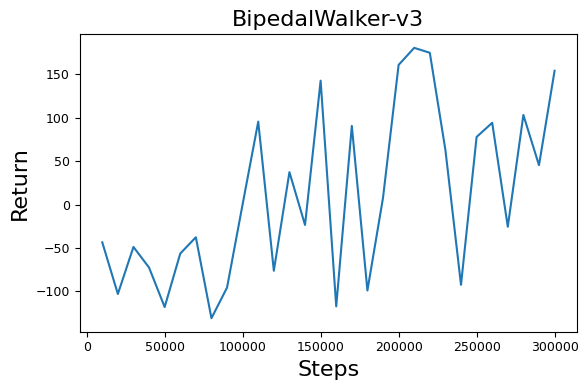

In [ ]:
ENV_ID = 'BipedalWalker-v3'
# ENV_ID = 'HalfCheetahBulletEnv-v0'
SEED = 0
NUM_STEPS = 3 * 10 ** 5
EVAL_INTERVAL = 10 ** 4

env = gym.make(ENV_ID)
env_test = gym.make(ENV_ID)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    lambd=0.9,  # 変更箇所
    seed=SEED,
    device=torch.device('cpu')
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)
trainer.train()
trainer.plot()


In [ ]:
env = gym.make(ENV_ID)
monitor_env = gnwrapper.Monitor(env, size=(200, 200), directory='.', video_callable=lambda ep: True)

run_policy(monitor_env, trainer.algo)
monitor_env.display()


steps:   0%|          | 0/99999 [00:00<?, ?it/s]

'rl-video-episode-0.mp4'

In [ ]:
del env
del env_test
del algo
del trainer

### 4-3. 3rd trial

- PPO Actor の修正  
ネットワークの出力から行動の標準偏差への活性化関数を `softplus` に置き換えたものの、学習が進まず、学習途中でエラーが発生した。(Lidarに問題が発生した模様)
- 修正内容は以下の通り

```python
# --------------------------------------------
# before
# --------------------------------------------
class PPOActor(nn.Module):

```

```python
# --------------------------------------------
# after
# --------------------------------------------
class PPOActor(nn.Module):

```


Num steps: 10000    Return: -100.8   Time: 0:00:13
Num steps: 20000    Return: -36.3   Time: 0:00:30
Num steps: 30000    Return: -53.4   Time: 0:00:47
Num steps: 40000    Return: -45.2   Time: 0:01:04
Num steps: 50000    Return: -72.3   Time: 0:01:21
Num steps: 60000    Return: -72.6   Time: 0:01:38
Num steps: 70000    Return: -69.1   Time: 0:01:54
Num steps: 80000    Return: -53.0   Time: 0:02:11
Num steps: 90000    Return: -112.0   Time: 0:02:24
Num steps: 100000   Return: -111.9   Time: 0:02:38
Num steps: 110000   Return: 11.9    Time: 0:02:54
Num steps: 120000   Return: -81.7   Time: 0:03:08
Num steps: 130000   Return: 38.9    Time: 0:03:24
Num steps: 140000   Return: 55.4    Time: 0:03:40
Num steps: 150000   Return: -2.7    Time: 0:03:56
Num steps: 160000   Return: -94.1   Time: 0:04:10
Num steps: 170000   Return: 119.7   Time: 0:04:26
Num steps: 180000   Return: -24.5   Time: 0:04:41
Num steps: 190000   Return: -25.2   Time: 0:04:56
Num steps: 200000   Return: -94.1   Time: 0:05:

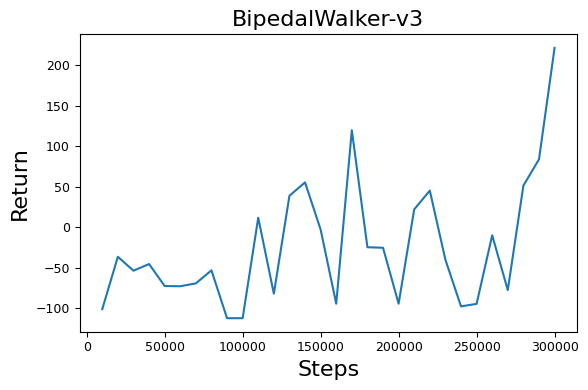

In [ ]:
ENV_ID = 'BipedalWalker-v3'
# ENV_ID = 'HalfCheetahBulletEnv-v0'
SEED = 0
NUM_STEPS = 3 * 10 ** 5
EVAL_INTERVAL = 10 ** 4

env = gym.make(ENV_ID)
env_test = gym.make(ENV_ID)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device('cpu')
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)
trainer.train()
trainer.plot()


In [ ]:
env = gym.make(ENV_ID)
monitor_env = gnwrapper.Monitor(env, size=(200, 200), directory='.', video_callable=lambda ep: True)

run_policy(monitor_env, trainer.algo)
monitor_env.display()


steps:   0%|          | 0/99999 [00:00<?, ?it/s]

'rl-video-episode-0.mp4'

### 4-4. 4th trial

- 2nd trial の修正を維持し、それに加えて以下の修正を行った
- PPO Actor の修正  
最終層のネットワークパラメータの値を小さな値へと書き換えた
- 修正内容は以下の通り


```python
# --------------------------------------------
# before
# --------------------------------------------
class PPOActor(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_shape[0]),
        )
        self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))
```

```python
# --------------------------------------------
# after
# --------------------------------------------
class PPOActor(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_shape[0]),
        )

        # Overwrite weights and biases by small values.
        with torch.no_grad():
            self.net[-1].weight.mul_(0.01)

        nn.init.constant_(self.net[-1].bias, 0)

        self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))
```


Num steps: 10000    Return: -104.2   Time: 0:00:15
Num steps: 20000    Return: -34.0   Time: 0:00:32
Num steps: 30000    Return: -72.7   Time: 0:00:49
Num steps: 40000    Return: -74.6   Time: 0:01:07
Num steps: 50000    Return: -70.7   Time: 0:01:24
Num steps: 60000    Return: -45.9   Time: 0:01:41
Num steps: 70000    Return: -33.2   Time: 0:01:59
Num steps: 80000    Return: -36.5   Time: 0:02:16
Num steps: 90000    Return: -43.0   Time: 0:02:32
Num steps: 100000   Return: 119.6   Time: 0:02:49
Num steps: 110000   Return: -17.4   Time: 0:03:05
Num steps: 120000   Return: 123.9   Time: 0:03:23
Num steps: 130000   Return: -77.5   Time: 0:03:38
Num steps: 140000   Return: -94.9   Time: 0:03:52
Num steps: 150000   Return: -112.3   Time: 0:04:07
Num steps: 160000   Return: -35.1   Time: 0:04:22
Num steps: 170000   Return: 6.3     Time: 0:04:38
Num steps: 180000   Return: 243.6   Time: 0:04:54
Num steps: 190000   Return: 143.1   Time: 0:05:11
Num steps: 200000   Return: -106.1   Time: 0:05:

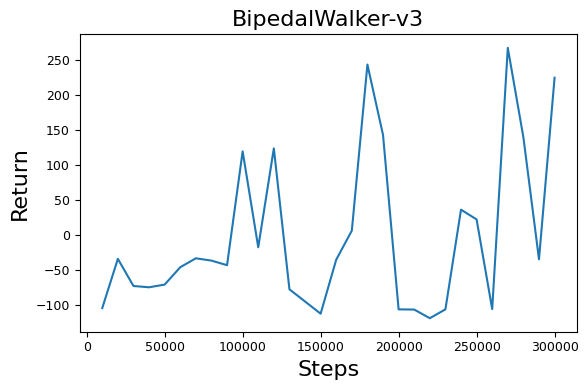

In [ ]:
ENV_ID = 'BipedalWalker-v3'
# ENV_ID = 'HalfCheetahBulletEnv-v0'
SEED = 0
NUM_STEPS = 3 * 10 ** 5
EVAL_INTERVAL = 10 ** 4

env = gym.make(ENV_ID)
env_test = gym.make(ENV_ID)

algo = PPO(
    state_shape=env.observation_space.shape,
    lambd=0.9,  # 変更維持
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device('cpu')
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)
trainer.train()
trainer.plot()


In [ ]:
env = gym.make(ENV_ID)
monitor_env = gnwrapper.Monitor(env, size=(200, 200), directory='.', video_callable=lambda ep: True)

run_policy(monitor_env, trainer.algo)
monitor_env.display()


steps:   0%|          | 0/99999 [00:00<?, ?it/s]

'rl-video-episode-0.mp4'

### 4-5. 5th trial

- 2nd, 4th trial の修正を維持したまま、以下の修正を実施。
- 割引率 $\gamma$ を 0.99 に設定。

Num steps: 10000    Return: -83.9   Time: 0:00:19
Num steps: 20000    Return: -48.4   Time: 0:00:39
Num steps: 30000    Return: -64.9   Time: 0:00:59
Num steps: 40000    Return: -57.5   Time: 0:01:16
Num steps: 50000    Return: -45.3   Time: 0:01:33
Num steps: 60000    Return: -36.4   Time: 0:01:52
Num steps: 70000    Return: -45.9   Time: 0:02:09
Num steps: 80000    Return: 88.7    Time: 0:02:26
Num steps: 90000    Return: 125.5   Time: 0:02:42
Num steps: 100000   Return: 147.4   Time: 0:02:59
Num steps: 110000   Return: -101.3   Time: 0:03:14
Num steps: 120000   Return: 261.4   Time: 0:03:31
Num steps: 130000   Return: 245.7   Time: 0:03:48
Num steps: 140000   Return: 164.4   Time: 0:04:05
Num steps: 150000   Return: 174.2   Time: 0:04:21
Num steps: 160000   Return: 172.6   Time: 0:04:37
Num steps: 170000   Return: 192.5   Time: 0:04:54
Num steps: 180000   Return: 212.8   Time: 0:05:09
Num steps: 190000   Return: 147.2   Time: 0:05:26
Num steps: 200000   Return: 278.5   Time: 0:05:43

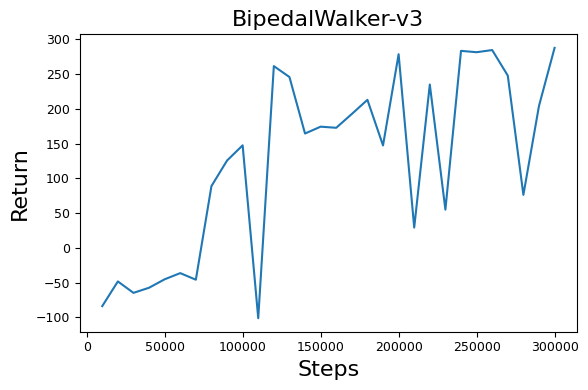

In [ ]:
ENV_ID = 'BipedalWalker-v3'
# ENV_ID = 'HalfCheetahBulletEnv-v0'
SEED = 0
NUM_STEPS = 3 * 10 ** 5
EVAL_INTERVAL = 10 ** 4

env = gym.make(ENV_ID)
env_test = gym.make(ENV_ID)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    gamma=0.99, lambd=0.9,  # 変更箇所
    seed=SEED,
    device=torch.device('cpu')
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
)
trainer.train()
trainer.plot()


In [ ]:
env = gym.make(ENV_ID)
monitor_env = gnwrapper.Monitor(env, size=(200, 200), directory='.', video_callable=lambda ep: True)

run_policy(monitor_env, trainer.algo)
monitor_env.display()


steps:   0%|          | 0/99999 [00:00<?, ?it/s]

'rl-video-episode-0.mp4'